<a href="https://colab.research.google.com/github/TrinhHoangKhang/AIO-2024/blob/main/Homework/Module2/Projects/Stereo%20matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Dowload dataset
!gdown 14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ

Downloading...
From: https://drive.google.com/uc?id=14gf8bcym_lTcvjZQmg8kwq3aXkENBxMQ
To: /content/tsukuba.zip
100% 354k/354k [00:00<00:00, 44.2MB/s]


In [2]:
!unzip tsukuba.zip -d tsukuba

Archive:  tsukuba.zip
mapname:  conversion of  failed
 extracting: tsukuba/left.png        
 extracting: tsukuba/right.png       
 extracting: tsukuba/groundtruth.png  


In [3]:
!gdown 1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
!unzip Aloe_images.zip

Downloading...
From: https://drive.google.com/uc?id=1wxmiUdqMciuTOs0ouKEISl8-iTVXdOWn
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 125MB/s]
Archive:  Aloe_images.zip
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


In [4]:
# Import library
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### Problem 1: Pixel-wise matching

In [5]:
tsukuba_left_path = '/content/tsukuba/left.png'
tsukiba_right_path = '/content/tsukuba/right.png'
aloe_left_path = '/content/Aloe/Aloe_left_1.png'
aloe_right_path_1 = '/content/Aloe/Aloe_right_1.png'
aloe_right_path_2 = '/content/Aloe/Aloe_right_2.png'
aloe_right_path_3 = '/content/Aloe/Aloe_right_3.png'

path_ls = [tsukuba_left_path,
          tsukiba_right_path,
          aloe_left_path,
          aloe_right_path_1,
          aloe_right_path_2,
          aloe_right_path_3]

img_ls = [np.array(Image.open(path).convert('L')).astype(np.float32) for path in path_ls]

tsukuba_left, tsukuba_right, aloe_left, aloe_right_1, aloe_right_2, aloe_right_3 = img_ls

# Some info about image:
# - Channel: 1
# - Datatype: np.array
# - Element type: float32

In [6]:
def create_disparity_map_pixel(left_image, right_image, d_range):
  # Get the shape
  height, width = left_image.shape
  # Initialize the disparity map
  disparity = np.zeros_like(left_image)

  # Calculate
  for y in range(height):
    for x in range(width):
      min_distance = 255
      final_disparity = int()
      for d in range(0, d_range):
        if x - d >= 0:
          current_distance = np.abs(left_image[y, x] - right_image[y, x - d])
          if current_distance < min_distance:
            min_distance = current_distance
            final_disparity = d

      disparity[y, x] = final_disparity

  return disparity

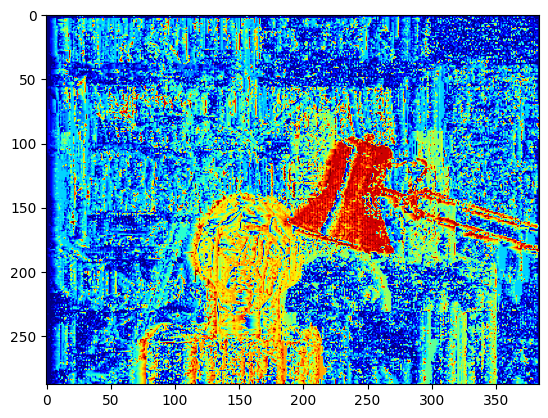

In [7]:
disparity = create_disparity_map_pixel(tsukuba_left, tsukuba_right, 16)
plt.imshow(disparity, cmap='jet') # Auto normalize by plt

#### Window-based matching

In [17]:
def create_disparity_map_window(left_image, right_image, d_range, window_half_size):
  # Get the shape
  height, width = left_image.shape
  # Initialize the disparity map
  disparity = np.zeros_like(left_image)

  # Calculate
  for y in range(window_half_size, height - window_half_size):
    for x in range(window_half_size, width - window_half_size):
      min_distance = 255*9
      final_disparity = int()
      for d in range(0, d_range):
        if x - d - window_half_size >= 0:
          left_window = left_image[y-window_half_size:y+window_half_size+1, x-window_half_size:x+window_half_size+1]
          right_window = right_image[y-window_half_size:y+window_half_size+1, x-d-window_half_size:x-d+window_half_size+1]
          current_distance = np.sum(np.abs(left_window - right_window))

          if current_distance < min_distance:
            min_distance = current_distance
            final_disparity = d

      disparity[y, x] = final_disparity

  return disparity

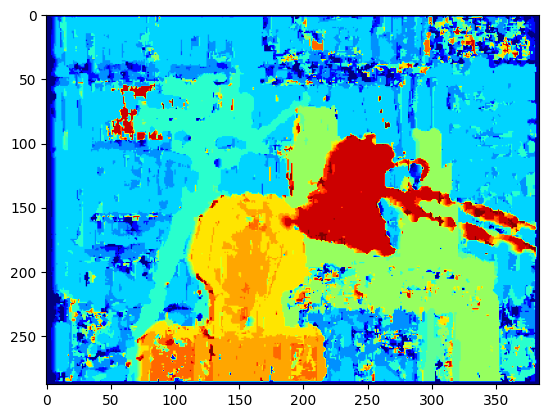

In [20]:
disparity = create_disparity_map_window(tsukuba_left, tsukuba_right, 16, 2)
plt.imshow(disparity, cmap='jet') # Auto normalize by plt

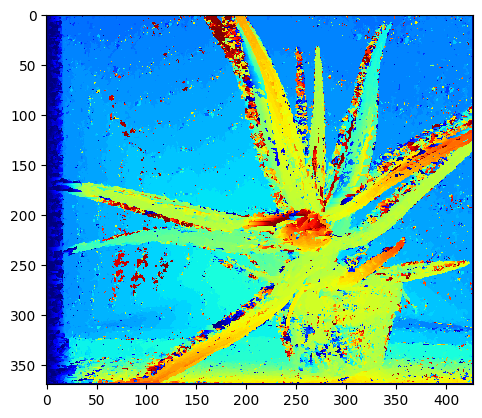

In [19]:
disparity = create_disparity_map_window(aloe_left, aloe_right_1, 64, 1)
plt.imshow(disparity, cmap='jet') # Auto normalize by plt

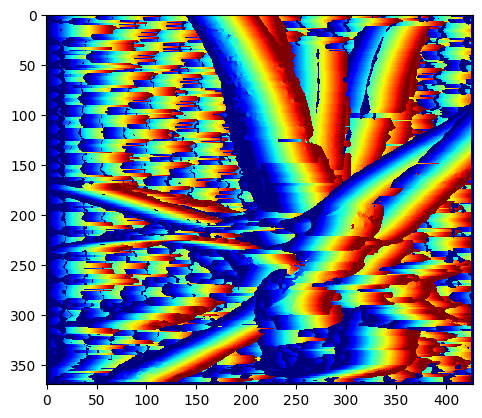

In [18]:
disparity = create_disparity_map_window(aloe_left, aloe_right_2, 64, 2)
plt.imshow(disparity, cmap='jet') # Auto normalize by plt

#### Window-based matching with cosine similarity

In [23]:
def cosine_similarity(v1, v2):
  return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

In [28]:
def create_disparity_map_window_cosine(left_image, right_image, d_range, window_half_size):
  # Get the shape
  height, width = left_image.shape
  # Initialize the disparity map
  disparity = np.zeros_like(left_image)

  # Calculate
  for y in range(window_half_size, height - window_half_size):
    for x in range(window_half_size, width - window_half_size):
      max_distance = -1
      final_disparity = int()
      for d in range(0, d_range):
        if x - d - window_half_size >= 0:
          left_window = left_image[y-window_half_size:y+window_half_size+1, x-window_half_size:x+window_half_size+1]
          right_window = right_image[y-window_half_size:y+window_half_size+1, x-d-window_half_size:x-d+window_half_size+1]
          current_distance = cosine_similarity(left_window.flatten(), right_window.flatten())

          if current_distance > max_distance:
            max_distance = current_distance
            final_disparity = d

      disparity[y, x] = final_disparity

  return disparity

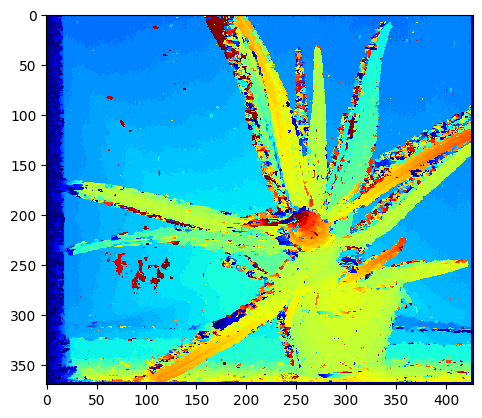

In [29]:
disparity = create_disparity_map_window_cosine(aloe_left, aloe_right_2, 64, 2)
plt.imshow(disparity, cmap='jet') # Auto normalize by plt